# Importing necessary things

In [1]:
#conda install -c conda-forge fbprophet
#conda install -c conda-forge/label/cf201901 fbprophet
#pip install fbprophet
#pip install holidays==0.9.12
#pip install --upgrade plotly

#conda install nb_conda jupyter
#pip install pmdarima

#conda install -c conda-forge tensorflow 
#pip install tensorflow 
#pip install --upgrade tensorflow-gpu
#pip install Keras

In [97]:
import pickle
import bz2

import pandas as pd
from pandas import concat
import time
import warnings                                  
warnings.filterwarnings('ignore')

import numpy as np                                                            
import matplotlib.pyplot as plt                  
import seaborn as sns    
from math import sqrt

from dateutil.relativedelta import relativedelta 
from scipy.optimize import minimize              

import statsmodels.formula.api as smf            
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
import scipy.stats as scs

from statsmodels.tsa.stattools import adfuller

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from fbprophet import Prophet

import xgboost as xgb
from xgboost import plot_importance, plot_tree

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import pmdarima as pm
from pmdarima import auto_arima
from pmdarima.arima import ADFTest
from pmdarima.arima.utils import ndiffs

from sklearn.preprocessing import MinMaxScaler

import tensorflow

------------

# Looking at the dataframe

In [98]:
# Bring dataset from pickle

def decompress_pickle(file):
    data = bz2.BZ2File(file, 'rb')
    data = pickle.load(data)
    return data

In [99]:
df = decompress_pickle('data/compressedpz.pbz2')
df.head()

,recommendationid,author,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,timestamp_dev_responded,developer_response
84652123,84652123,"{'steamid': '76561198044182675', 'num_games_ow...",english,Don't get me wrong this game is amazing. I spe...,1610600299,1610600299,False,0,0,0,0,True,False,True,NaN,NaN
84650292,84650292,"{'steamid': '76561198189260829', 'num_games_ow...",english,ME LIKE!!,1610596706,1610596706,True,0,0,0,0,True,False,True,NaN,NaN
84647357,84647357,"{'steamid': '76561197968351158', 'num_games_ow...",english,Really good game. Make sure you opt into the b...,1610591400,1610591400,True,0,0,0,0,True,False,True,NaN,NaN
84646408,84646408,"{'steamid': '76561198025117668', 'num_games_ow...",english,Project Zomboid is THE zombie survival game. W...,1610589741,1610589741,True,0,0,0,0,True,False,True,NaN,NaN
84643897,84643897,"{'steamid': '76561198024526105', 'num_games_ow...",english,Less of an action-packed zombie apocalypse gam...,1610585302,1610585302,True,0,0,0,0,True,False,True,NaN,NaN


------

# Cleaning the data

In [100]:
# Checking for null values
# Almost all the reviews have no responses from the dev.

df.isna().sum()

recommendationid                   0
author                             0
language                           0
review                             0
timestamp_created                  0
timestamp_updated                  0
voted_up                           0
votes_up                           0
votes_funny                        0
weighted_vote_score                0
comment_count                      0
steam_purchase                     0
received_for_free                  0
written_during_early_access        0
timestamp_dev_responded        33976
developer_response             33976
dtype: int64

In [101]:
# Dropping columns that are not particularly useful.

df = df.drop(columns=['recommendationid', 'author', 'timestamp_updated', 'timestamp_dev_responded', 'developer_response', 'written_during_early_access'])
df.head()

,language,review,timestamp_created,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free
84652123,english,Don't get me wrong this game is amazing. I spe...,1610600299,False,0,0,0,0,True,False
84650292,english,ME LIKE!!,1610596706,True,0,0,0,0,True,False
84647357,english,Really good game. Make sure you opt into the b...,1610591400,True,0,0,0,0,True,False
84646408,english,Project Zomboid is THE zombie survival game. W...,1610589741,True,0,0,0,0,True,False
84643897,english,Less of an action-packed zombie apocalypse gam...,1610585302,True,0,0,0,0,True,False


In [102]:
# Changing epoch time to readable format. Removing timestamp for ease of time series.
df['timestamp_created'] = [time.strftime('%Y-%m-%d', time.localtime(x)) for x in df['timestamp_created']]
df['timestamp_created'] = pd.to_datetime(df['timestamp_created'], format='%Y-%m-%d')

# Changing name of column for ease. 
df = df.rename(columns={'timestamp_created':'reviewtimeposted'})
df

,language,review,reviewtimeposted,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free
84652123,english,Don't get me wrong this game is amazing. I spe...,2021-01-13,False,0,0,0,0,True,False
84650292,english,ME LIKE!!,2021-01-13,True,0,0,0,0,True,False
84647357,english,Really good game. Make sure you opt into the b...,2021-01-13,True,0,0,0,0,True,False
84646408,english,Project Zomboid is THE zombie survival game. W...,2021-01-13,True,0,0,0,0,True,False
84643897,english,Less of an action-packed zombie apocalypse gam...,2021-01-13,True,0,0,0,0,True,False
...,...,...,...,...,...,...,...,...,...,...
7602280,english,This is a must buy! It's a really unique game ...,2013-11-08,True,0,0,0,0,False,False
7602237,english,Fans of serious zombie survival games that is ...,2013-11-08,True,20,0,0.715714693069458008,0,False,False
7602221,brazilian,Esse jogo é muito bacana para quem gosta de um...,2013-11-08,True,23,0,0.741350948810577393,0,False,False
7602166,english,"2013:After a really, really long wait it's fin...",2013-11-08,True,0,0,0,0,False,False


-----

# Checking distribution of reviews

In [103]:
# About half the reviews are in English as indicated by the reviewers.

df['language'].value_counts()

english       16263
russian        6942
schinese       2300
spanish        1552
brazilian      1416
french         1236
koreana         877
turkish         745
german          722
polish          550
tchinese        223
japanese        202
italian         199
latam           132
czech           103
thai             99
portuguese       90
dutch            65
swedish          63
finnish          46
danish           42
hungarian        41
ukrainian        32
norwegian        27
bulgarian         7
greek             6
vietnamese        5
romanian          5
Name: language, dtype: int64

In [104]:
# A large majority of people reviewed the game positively.

df['voted_up'].value_counts()

True     30418
False     3572
Name: voted_up, dtype: int64

In [105]:
# A large majority of people who made reviews purchased the game on Steam.

df['steam_purchase'].value_counts()

True     25751
False     8239
Name: steam_purchase, dtype: int64

In [106]:
# A vast majority of people who made reviews paid for the game.

df['received_for_free'].value_counts()

False    33521
True       469
Name: received_for_free, dtype: int64

----

# Removing outliers

## Hampel Filter

In [107]:
# Turning dataframe into time series format.

reviewcount = df['reviewtimeposted'].value_counts().rename_axis('date').reset_index(name='dailycount')
reviewcount = reviewcount.sort_values(by='date')
reviewcount.set_index('date', inplace=True)
reviewcount.head()

,dailycount
date,
2013-11-08,58
2013-11-09,46
2013-11-10,37
2013-11-11,21
2013-11-12,22


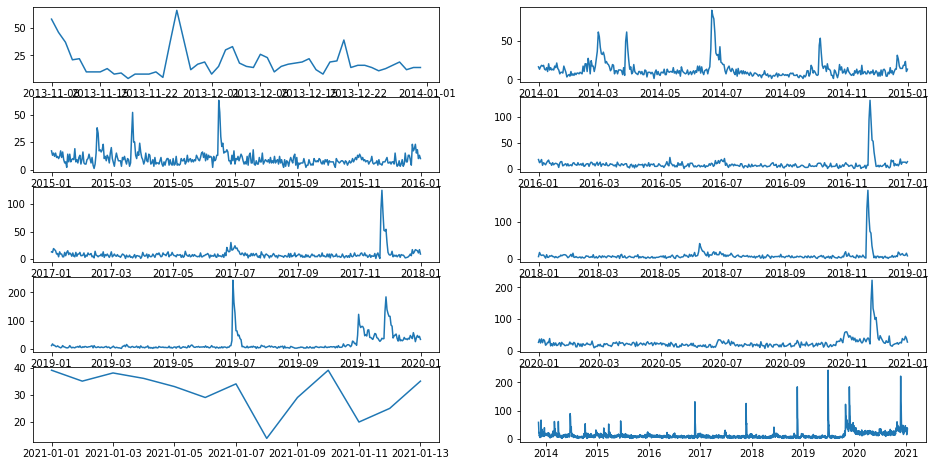

In [108]:
# Taking a look at number of reviews every year.

reviewcount13 = reviewcount['2013-01-01':'2013-12-31']
reviewcount14 = reviewcount['2014-01-01':'2014-12-31']
reviewcount15 = reviewcount['2015-01-01':'2015-12-31']
reviewcount16 = reviewcount['2016-01-01':'2016-12-31']
reviewcount17 = reviewcount['2017-01-01':'2017-12-31']
reviewcount18 = reviewcount['2018-01-01':'2018-12-31']
reviewcount19 = reviewcount['2019-01-01':'2019-12-31']
reviewcount20 = reviewcount['2020-01-01':'2020-12-31']
reviewcount21 = reviewcount['2021-01-01':'2021-12-31']

fig, axes = plt.subplots(5, 2, figsize=(16,8))

axes[0, 0].plot(reviewcount13)
axes[0, 1].plot(reviewcount14)
axes[1, 0].plot(reviewcount15)
axes[1, 1].plot(reviewcount16)
axes[2, 0].plot(reviewcount17)
axes[2, 1].plot(reviewcount18)
axes[3, 0].plot(reviewcount19)
axes[3, 1].plot(reviewcount20)
axes[4, 0].plot(reviewcount21)
axes[4, 1].plot(reviewcount)

plt.show()

In [109]:
def hampel(vals_orig, k=7, t0=3):
    
    # Don't overwrite original
    vals = vals_orig.copy()
    
    # Hampel Filter
    L = 1.4826
    rolling_median = vals.rolling(window=k, center=True).median()
    MAD = lambda x: np.median(np.abs(x - np.median(x)))
    rolling_MAD = vals.rolling(window=k, center=True).apply(MAD)
    threshold = t0 * L * rolling_MAD
    difference = np.abs(vals - rolling_median) 
    outlier_idx = difference > threshold
    vals[outlier_idx] = rolling_median[outlier_idx] 
    
    return(vals)

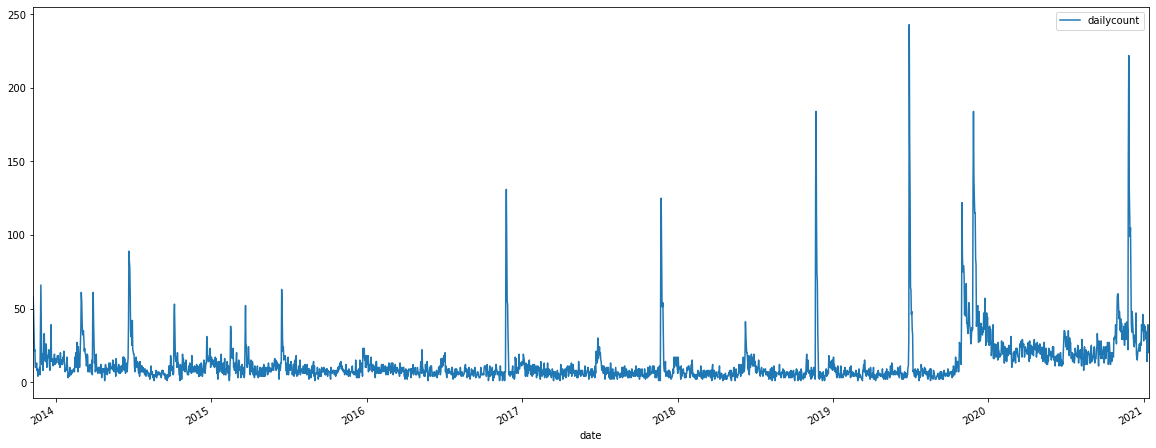

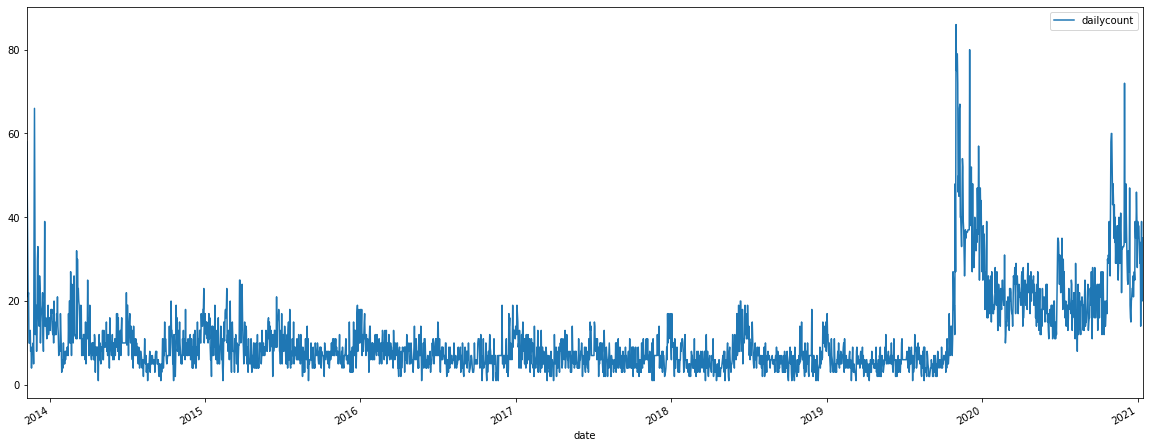

In [110]:
# k value chosen iteratively.

ts = reviewcount
hampts = hampel(ts, 90)

ts.plot(figsize = (20,8))
hampts.plot(figsize = (20,8))

plt.show()

In [111]:
# Adding a column with filtered values for later use.

reviewcount['dailycountfilter'] = pd.Series(hampts.values.flatten(), index=reviewcount.index)
reviewcount

,dailycount,dailycountfilter
date,,
2013-11-08,58,58.0
2013-11-09,46,46.0
2013-11-10,37,37.0
2013-11-11,21,21.0
2013-11-12,22,22.0
...,...,...
2021-01-09,29,29.0
2021-01-10,39,39.0
2021-01-11,20,20.0


In [112]:
# Checking how many values were changed from the original data.

reviewcount['filtered'] = np.where(reviewcount['dailycount'] == reviewcount['dailycountfilter'], True, False)
reviewcount['filtered'].value_counts()

True     2495
False     120
Name: filtered, dtype: int64

----

# Stationarity Tests

### Summary Statistics

Text(0.5, 1.0, 'Distribution of Daily # of Reviews')

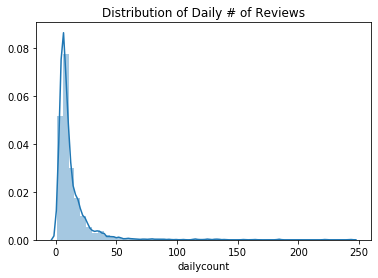

In [113]:
sns.distplot(reviewcount['dailycount'])
plt.title('Distribution of Daily # of Reviews')

In [114]:
X = reviewcount['dailycount'].values
split = round(len(X)/2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(),X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=10.279052, mean2=15.719204
variance1=90.387726, variance2=438.074941


Text(0.5, 1.0, 'Distribution of Daily # of Reviews')

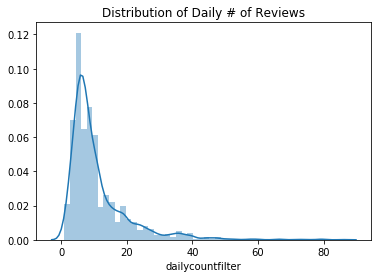

In [115]:
sns.distplot(reviewcount['dailycountfilter'])
plt.title('Distribution of Daily # of Reviews')

In [116]:
X = reviewcount['dailycountfilter'].values
split = round(len(X)/2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(),X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=8.976300, mean2=13.084162
variance1=27.172603, variance2=142.413728


### Dickey-Fuller Test

In [117]:
# This data is stationary within critical value 1%

dftest = adfuller(reviewcount['dailycount'])

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dftest)
print('----------------------------------')
print ('Results of Dickey-Fuller test: \n')

print(dfoutput)

(-4.899112181992308, 3.50133966639758e-05, 27, 2587, {'1%': -3.4328802668982084, '5%': -2.862657875000973, '10%': -2.5673650853551155}, 18845.897585169278)
----------------------------------
Results of Dickey-Fuller test: 

Test Statistic                   -4.899112
p-value                           0.000035
#Lags Used                       27.000000
Number of Observations Used    2587.000000
Critical Value (1%)              -3.432880
Critical Value (5%)              -2.862658
Critical Value (10%)             -2.567365
dtype: float64


In [118]:
# This data is stationary within critical value 5%.

dftest = adfuller(reviewcount['dailycountfilter'])

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dftest)
print('----------------------------------')
print ('Results of Dickey-Fuller test: \n')

print(dfoutput)

(-2.655577187551462, 0.08204580849300558, 28, 2586, {'1%': -3.4328812463201746, '5%': -2.8626583075270813, '10%': -2.5673653156355627}, 15079.719574627758)
----------------------------------
Results of Dickey-Fuller test: 

Test Statistic                   -2.655577
p-value                           0.082046
#Lags Used                       28.000000
Number of Observations Used    2586.000000
Critical Value (1%)              -3.432881
Critical Value (5%)              -2.862658
Critical Value (10%)             -2.567365
dtype: float64


### Looking at ACF and PACF

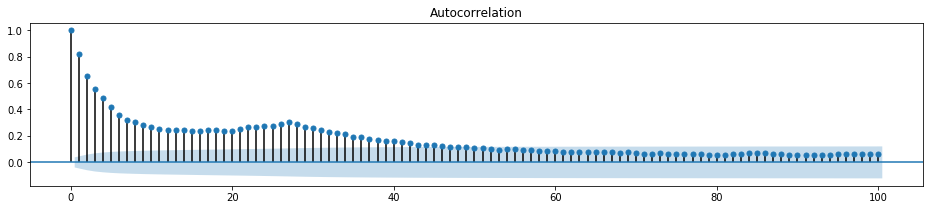

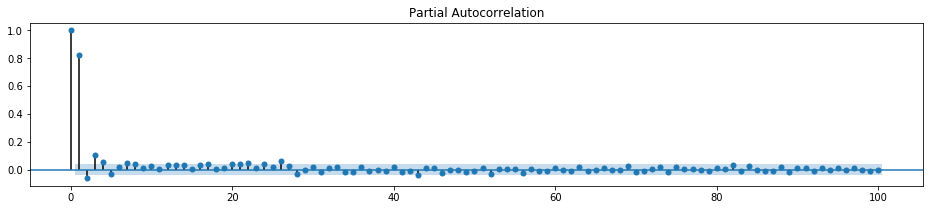

In [119]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(16,3))
plot_acf(reviewcount['dailycount'], ax=ax, lags=100);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(reviewcount['dailycount'], ax=ax, lags=100);

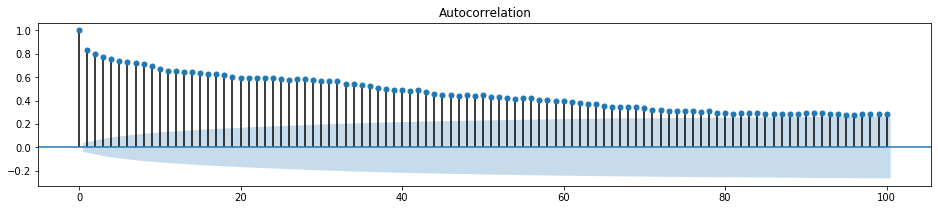

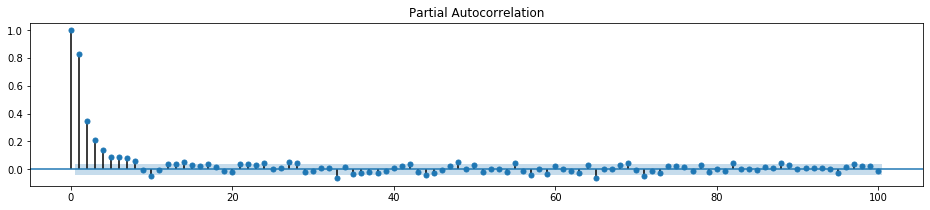

In [120]:
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(reviewcount['dailycountfilter'], ax=ax, lags=100);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(reviewcount['dailycountfilter'], ax=ax, lags=100);

------

# Forecast Modeling

In [121]:
# I chose this split date as the data is unusual due to a spike in reviews near the beginning of 2020.

split_date='2020-07-01'

train=reviewcount.loc[reviewcount.index <= split_date].copy()
test=reviewcount.loc[reviewcount.index > split_date].copy()

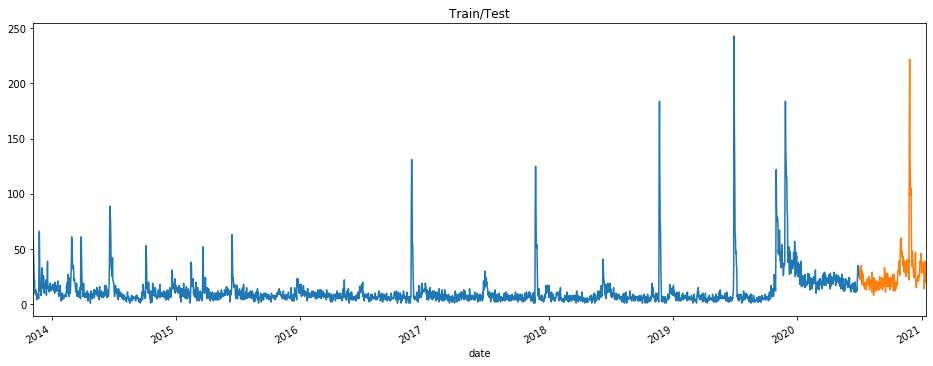

In [122]:
# Blue shows train data, orange shows test data.

train['dailycount'].plot(figsize=(16,6), title='Train/Test')
test['dailycount'].plot(figsize=(16,6), title='Train/Test')
plt.show()

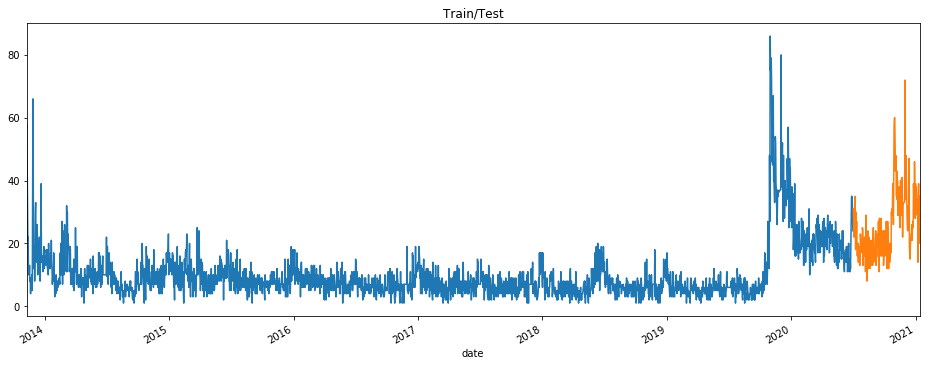

In [123]:
# Blue shows train data, orange shows test data.

train['dailycountfilter'].plot(figsize=(16,6), title='Train/Test')
test['dailycountfilter'].plot(figsize=(16,6), title='Train/Test')
plt.show()

----

## Naive Forecast

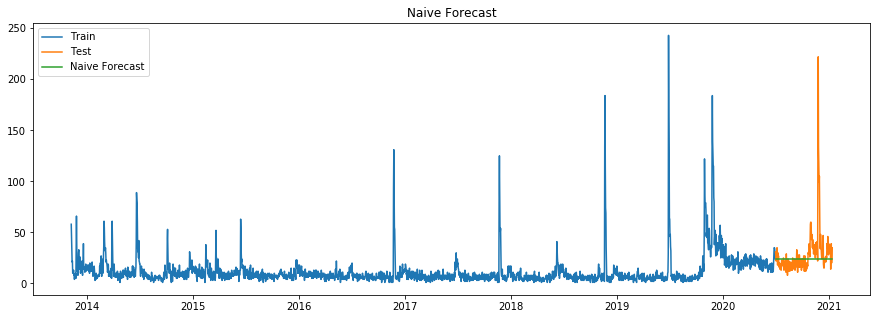

In [124]:
number = np.asarray(train['dailycount'])
y_hat = test.copy()
y_hat['naive'] = number[len(number)-1]

plt.figure(figsize=(15,5))
plt.plot(train.index, train['dailycount'], label='Train')
plt.plot(test.index,test['dailycount'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

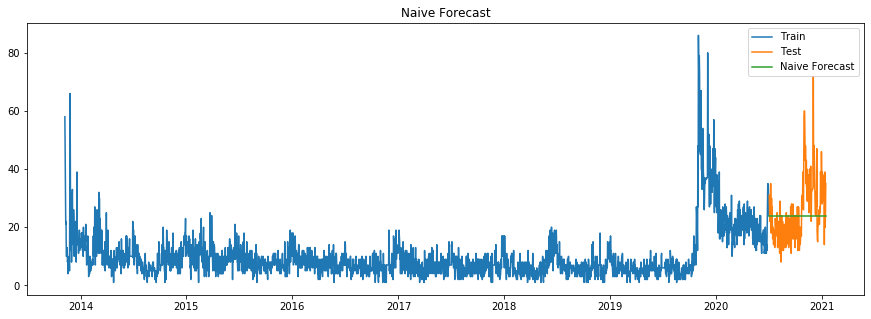

In [125]:
numberf = np.asarray(train['dailycountfilter'])
y_hatf = test.copy()
y_hatf['naive'] = number[len(number)-1]

plt.figure(figsize=(15,5))
plt.plot(train.index, train['dailycountfilter'], label='Train')
plt.plot(test.index,test['dailycountfilter'], label='Test')
plt.plot(y_hat.index,y_hatf['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

In [127]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

###########################################################

print(r2_score(y_true=test['dailycount'],
               y_pred=y_hat['naive']))

print(mean_squared_error(y_true=test['dailycount'],
                         y_pred=y_hat['naive']))

print(mean_absolute_error(y_true=test['dailycount'],
                         y_pred=y_hat['naive']))

print(mean_absolute_percentage_error(y_true=test['dailycount'],
                         y_pred=y_hat['naive']))

print(sqrt(mean_squared_error(test['dailycount'], y_hat['naive'])))


print('-------------------')

print(r2_score(y_true=test['dailycountfilter'],
               y_pred=y_hatf['naive']))

print(mean_squared_error(y_true=test['dailycountfilter'],
                         y_pred=y_hatf['naive']))

print(mean_absolute_error(y_true=test['dailycountfilter'],
                         y_pred=y_hatf['naive']))

print(mean_absolute_percentage_error(y_true=test['dailycountfilter'],
                         y_pred=y_hatf['naive']))

print(sqrt(mean_squared_error(test['dailycountfilter'], y_hatf['naive'])))

-0.04364652356950027
564.1122448979592
11.122448979591837
34.24892097861555
23.751047237921092
-------------------
-0.022196028116201916
109.69770408163265
7.85969387755102
32.581425187657466
10.473667174472972


## Prophet

In [128]:
tsprophet = train.drop(columns=['dailycountfilter', 'filtered'])
tsprophet = tsprophet.reset_index()
tsprophet = tsprophet.rename(columns={'date':'ds', 'dailycount':'y'})

tsprophettest = test.drop(columns=['dailycountfilter', 'filtered'])
tsprophettest = tsprophettest.reset_index()
tsprophettest = tsprophettest.rename(columns={'date':'ds', 'dailycount':'y'})

tsprophetf = train.drop(columns=['dailycount', 'filtered'])
tsprophetf = tsprophetf.reset_index()
tsprophetf = tsprophetf.rename(columns={'date':'ds', 'dailycountfilter':'y'})

tsprophettestf = test.drop(columns=['dailycount', 'filtered'])
tsprophettestf = tsprophettestf.reset_index()
tsprophettestf = tsprophettestf.rename(columns={'date':'ds', 'dailycountfilter':'y'})

In [129]:
model = Prophet() 
model.fit(tsprophet) 

testforecast = model.predict(df=tsprophettest)
testforecast.head()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-07-02,28.267254,20.456301,54.199393,28.267254,28.267254,9.017045,9.017045,9.017045,-0.796653,-0.796653,-0.796653,9.813697,9.813697,9.813697,0.0,0.0,0.0,37.284299
1,2020-07-03,28.303176,20.583124,54.905822,28.303176,28.303176,9.111015,9.111015,9.111015,-0.170404,-0.170404,-0.170404,9.281420,9.281420,9.281420,0.0,0.0,0.0,37.414192
2,2020-07-04,28.339098,22.195083,55.945254,28.339098,28.339098,10.054087,10.054087,10.054087,1.419037,1.419037,1.419037,8.635050,8.635050,8.635050,0.0,0.0,0.0,38.393186
3,2020-07-05,28.375020,22.166961,54.433934,28.375020,28.375020,9.013363,9.013363,9.013363,1.127449,1.127449,1.127449,7.885914,7.885914,7.885914,0.0,0.0,0.0,37.388383
4,2020-07-06,28.410942,18.991697,51.362765,28.410942,28.410942,6.795122,6.795122,6.795122,-0.252144,-0.252144,-0.252144,7.047266,7.047266,7.047266,0.0,0.0,0.0,35.206064


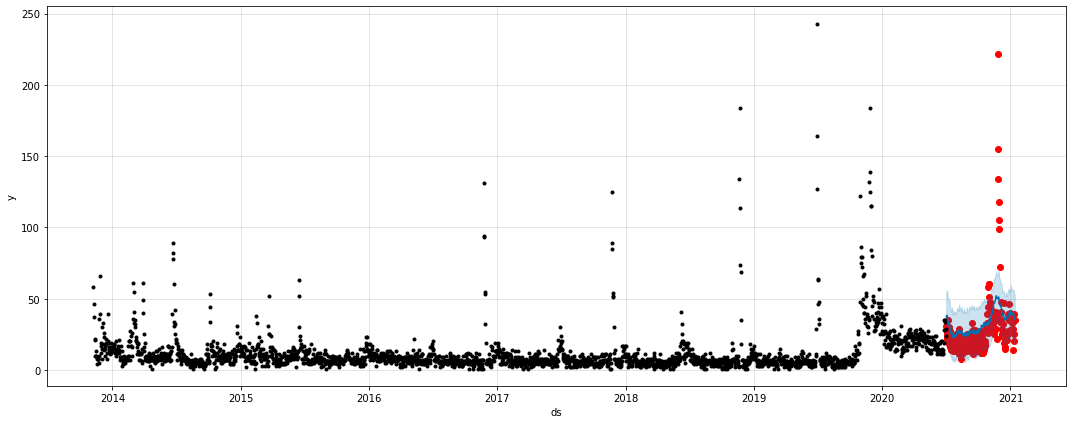

In [130]:
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)
ax.scatter(tsprophettest['ds'],tsprophettest['y'], color='r')
fig = model.plot(testforecast, ax=ax)
plt.show()

In [131]:
model2 = Prophet() 
model2.fit(tsprophetf) 

testforecastf = model.predict(df=tsprophettestf)
testforecastf.head()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-07-02,28.267254,21.056157,53.357458,28.267254,28.267254,9.017045,9.017045,9.017045,-0.796653,-0.796653,-0.796653,9.813697,9.813697,9.813697,0.0,0.0,0.0,37.284299
1,2020-07-03,28.303176,18.361878,52.774656,28.303176,28.303176,9.111015,9.111015,9.111015,-0.170404,-0.170404,-0.170404,9.281420,9.281420,9.281420,0.0,0.0,0.0,37.414192
2,2020-07-04,28.339098,21.232222,55.741193,28.339098,28.339098,10.054087,10.054087,10.054087,1.419037,1.419037,1.419037,8.635050,8.635050,8.635050,0.0,0.0,0.0,38.393186
3,2020-07-05,28.375020,19.617420,54.072982,28.375020,28.375020,9.013363,9.013363,9.013363,1.127449,1.127449,1.127449,7.885914,7.885914,7.885914,0.0,0.0,0.0,37.388383
4,2020-07-06,28.410942,18.303367,51.143576,28.410942,28.410942,6.795122,6.795122,6.795122,-0.252144,-0.252144,-0.252144,7.047266,7.047266,7.047266,0.0,0.0,0.0,35.206064


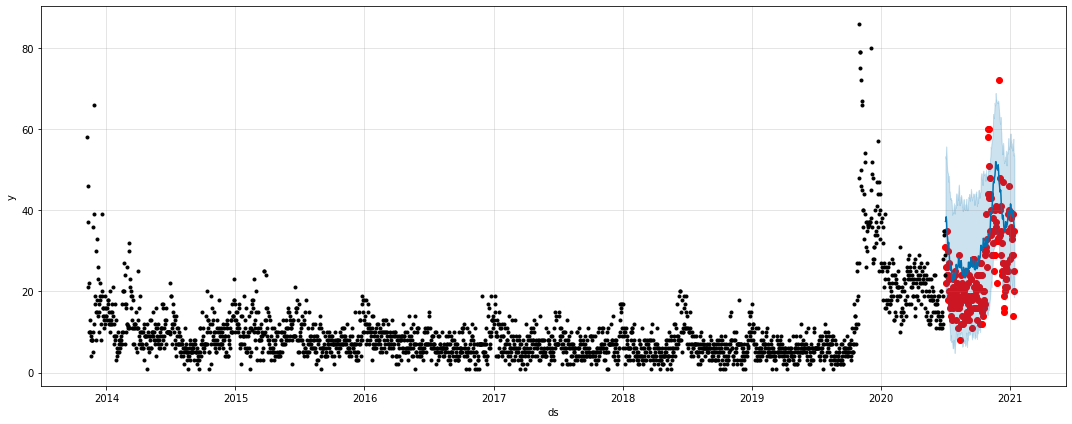

In [132]:
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)
ax.scatter(tsprophettestf['ds'],tsprophettestf['y'], color='r')
fig = model2.plot(testforecastf, ax=ax)
plt.show()

In [133]:
print(r2_score(y_true=tsprophettest['y'],
               y_pred=testforecast['yhat']))

print(mean_squared_error(y_true=tsprophettest['y'],
                         y_pred=testforecast['yhat']))

print(mean_absolute_error(y_true=tsprophettest['y'],
                         y_pred=testforecast['yhat']))

print(mean_absolute_percentage_error(y_true=tsprophettest['y'],
                         y_pred=testforecast['yhat']))

print(sqrt(mean_squared_error(tsprophettest['y'], testforecast['yhat'])))

print('-------------------')

print(r2_score(y_true=tsprophettestf['y'],
               y_pred=testforecastf['yhat']))

print(mean_squared_error(y_true=tsprophettestf['y'],
                         y_pred=testforecastf['yhat']))

print(mean_absolute_error(y_true=tsprophettestf['y'],
                         y_pred=testforecastf['yhat']))

print(mean_absolute_percentage_error(y_true=tsprophettestf['y'],
                         y_pred=testforecastf['yhat']))

print(sqrt(mean_squared_error(tsprophettestf['y'], testforecastf['yhat'])))

0.24708421512042555
406.96634735567284
11.534701969750031
44.53169378768569
20.173406934766195
-------------------
-0.13874712272895096
122.20546886994023
9.361287241080731
44.41705405936208
11.054658243018652


## XGBoost

In [134]:
def create_features(dfx, label=None):
    """
    Creates time series features from datetime index
    """
    dfx['date'] = dfx.index
    dfx['dayofweek'] = dfx['date'].dt.dayofweek
    dfx['quarter'] = dfx['date'].dt.quarter
    dfx['month'] = dfx['date'].dt.month
    dfx['year'] = dfx['date'].dt.year
    dfx['dayofyear'] = dfx['date'].dt.dayofyear
    dfx['dayofmonth'] = dfx['date'].dt.day
    dfx['weekofyear'] = dfx['date'].dt.weekofyear
    
    X = dfx[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = dfx[label]
        return X, y
    return X

In [135]:
X_train, y_train = create_features(train, label='dailycount')
X_test, y_test = create_features(test, label='dailycount')

X_trainf, y_trainf = create_features(train, label='dailycountfilter')
X_testf, y_testf = create_features(test, label='dailycountfilter')

In [136]:
reg = xgb.XGBRegressor(n_estimators=1000)
regf = xgb.XGBRegressor(n_estimators=1000)

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

regf.fit(X_trainf, y_trainf,
        eval_set=[(X_trainf, y_trainf), (X_testf, y_testf)],
        early_stopping_rounds=50,
       verbose=False)

[18:15:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:15:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=1000)

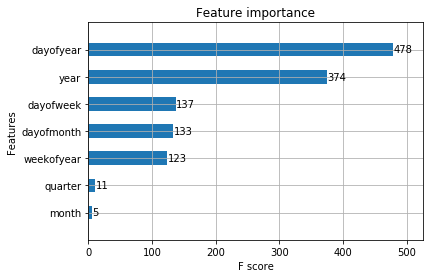

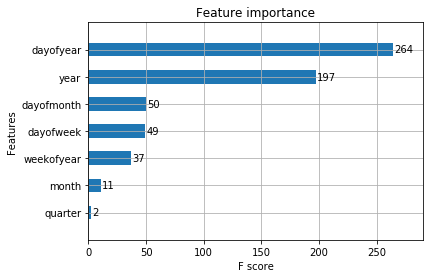

In [137]:
_ = plot_importance(reg, height=0.5)
_ = plot_importance(regf, height=0.5)

In [138]:
test['prediction'] = reg.predict(X_test)
test['predictionf'] = reg.predict(X_testf)

dfall = pd.concat([test, train], sort=False)

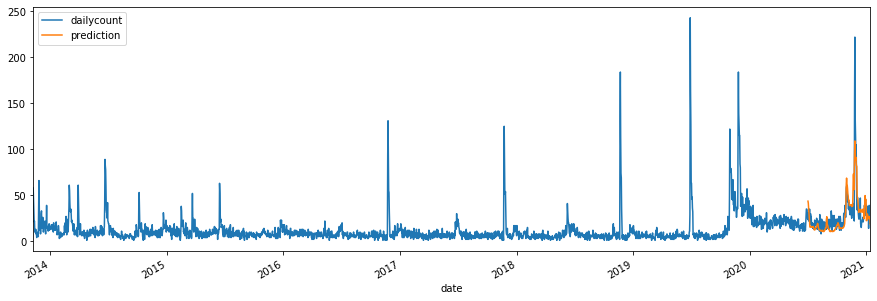

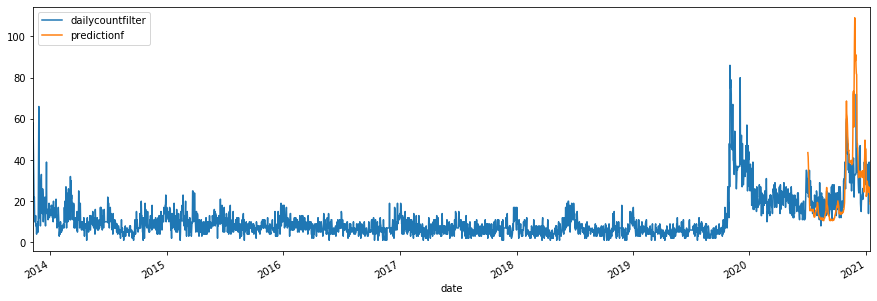

In [139]:
_ = dfall[['dailycount','prediction']].plot(figsize=(15, 5))
_ = dfall[['dailycountfilter','predictionf']].plot(figsize=(15, 5))

In [140]:
print(r2_score(y_true=test['dailycount'],
               y_pred=test['prediction']))

print(mean_squared_error(y_true=test['dailycount'],
                         y_pred=test['prediction']))

print(mean_absolute_error(y_true=test['dailycount'],
                         y_pred=test['prediction']))

print(mean_absolute_percentage_error(y_true=test['dailycount'],
                         y_pred=test['prediction']))

print(sqrt(mean_squared_error(test['dailycount'], test['prediction'])))

print('-------------------')

print(r2_score(y_true=test['dailycountfilter'],
               y_pred=test['predictionf']))

print(mean_squared_error(y_true=test['dailycountfilter'],
                         y_pred=test['predictionf']))

print(mean_absolute_error(y_true=test['dailycountfilter'],
                         y_pred=test['predictionf']))

print(mean_absolute_percentage_error(y_true=test['dailycountfilter'],
                         y_pred=test['predictionf']))

print(sqrt(mean_squared_error(test['dailycountfilter'], test['predictionf'])))

0.6235531409606847
203.47720989970986
8.818258334179314
30.725074742851348
14.26454380271973
-------------------
-1.0723830278131445
222.39927946873314
9.268972445507439
35.46063322499003
14.913057348133988


## pmdarima

In [141]:
adftest = ADFTest(alpha=0.05)

print(adftest.should_diff(reviewcount['dailycount']))
print(adftest.should_diff(reviewcount['dailycountfilter']))

(0.01, False)
(0.01, False)


In [142]:
# If done using full stepwise then:
# Best model:  ARIMA(5,1,0)(5,1,0)[12]          
# Total fit time: 1272.888 seconds

autoarima = auto_arima(train['dailycount'], start_p=5, d=1, start_q=0,
                       max_p=5, max_d=2, max_q=2, start_P=5,
                       D=1, start_Q=0, max_P=5, max_D=2,
                       max_Q=2, m=12, seasonal=True,
                       error_action='warn', trace=True,
                       supress_warnings=True, stepwise=True,
                       random_state=55, n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(5,1,0)(5,1,0)[12]             : AIC=17842.787, Time=11.09 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=19303.139, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=18559.890, Time=0.53 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=2.73 sec
 ARIMA(5,1,0)(4,1,0)[12]             : AIC=17893.787, Time=6.65 sec
 ARIMA(5,1,0)(5,1,1)[12]             : AIC=inf, Time=143.18 sec
 ARIMA(5,1,0)(4,1,1)[12]             : AIC=inf, Time=88.80 sec
 ARIMA(4,1,0)(5,1,0)[12]             : AIC=17859.873, Time=14.83 sec
 ARIMA(5,1,1)(5,1,0)[12]             : AIC=inf, Time=136.79 sec
 ARIMA(4,1,1)(5,1,0)[12]             : AIC=inf, Time=98.95 sec
 ARIMA(5,1,0)(5,1,0)[12] intercept   : AIC=17844.770, Time=80.98 sec

Best model:  ARIMA(5,1,0)(5,1,0)[12]          
Total fit time: 584.673 seconds


In [143]:
autoarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 2419
Model:             SARIMAX(5, 1, 0)x(5, 1, 0, 12)   Log Likelihood               -8910.394
Date:                            Sun, 21 Feb 2021   AIC                          17842.787
Time:                                    18:28:49   BIC                          17906.430
Sample:                                         0   HQIC                         17865.938
                                           - 2419                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0714      0.005    -13.009      0.000      -0.082      -0.061
ar.L2         -0.1760      0.011    -15.699      0.000      -0.198      -0.154
ar.L3         -0.1630      0.009    -18.238      0.000      -0.181      -0.145
ar.L4         -0.0366      0.015     -2.447      0.014      -0.066      -0.007
ar.L5         -0.0890      0.012     -7.542      0.000      -0.112      -0.066
ar.S.L12      -0.8673      0.009    -92.061      0.000      -0.886      -0.849
ar.S.L24      -0.6732      0.012    -54.597      0.000      -0.697      -0.649
ar.S.L36      -0.4919      0.013    -37.273      0.000      -0.518      -0.466
ar.S.L48      -0.3266      0.013    -25.704      0.000      -0.352      -0.302
ar.S.L60      -0.1480      0.010    -14.284      0.000      -0.168      -0.128
sigma2        95.9406      0.351    272.969      0.000      95.252      96.629
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):           1666529.34
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               3.38   Skew:                             6.63
Prob(H) (two-sided):                  0.00   Kurtosis:                       131.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [144]:
autoarimapredict = pd.DataFrame(autoarima.predict(n_periods=196), index=test.index)
autoarimapredict.columns = ['predicted']
autoarimapredict.head()

,predicted
date,
2020-07-02,24.879089
2020-07-03,27.250080
2020-07-04,24.236779
2020-07-05,24.613715
2020-07-06,27.470936


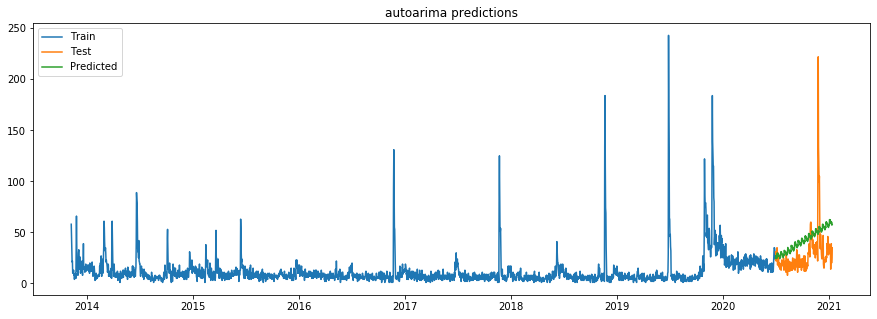

In [145]:
plt.figure(figsize=(15,5))
plt.plot(train.index, train['dailycount'], label='Train')
plt.plot(test.index, test['dailycount'], label='Test')
plt.plot(autoarimapredict.index, autoarimapredict['predicted'], label='Predicted')
plt.legend(loc='best')
plt.title("Autoarima Predictions")
plt.show()

In [150]:
print(r2_score(y_true=test['dailycount'],
               y_pred=autoarimapredict['predicted']))

print(mean_squared_error(y_true=test['dailycount'],
                         y_pred=autoarimapredict['predicted']))

print(mean_absolute_error(y_true=test['dailycount'],
                         y_pred=autoarimapredict['predicted']))

print(mean_absolute_percentage_error(y_true=test['dailycount'],
                         y_pred=autoarimapredict['predicted']))

print(sqrt(mean_squared_error(test['dailycount'], autoarimapredict['predicted'])))

-0.2458540094233741
673.4095176853627
19.712605874728695
84.04734843302037
25.95013521516531


## LSTM network

In [55]:
print(len(train['dailycount']))
print(len(test['dailycount']))

2419
196


In [56]:
def timeseries_to_supervised(data, lag=1):
	df = pd.DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

In [57]:
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

In [58]:
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

In [59]:
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

In [60]:
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

In [61]:
supervised = timeseries_to_supervised(reviewcount['dailycount'], 1)
supervised_values = supervised.values

In [62]:
train, test = supervised_values[0:-196], supervised_values[-196:]

In [63]:
scaler, train_scaled, test_scaled = scale(train, test)

In [66]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from datetime import datetime

starttime = datetime.now()

#######

lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

#######

print(datetime.now() - starttime)

1:01:13.338128


In [67]:
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

In [74]:
raw_values = reviewcount['dailycount'].values

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Day=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Day=1, Predicted=48.105993, Expected=26.000000
Day=2, Predicted=60.115986, Expected=22.000000
Day=3, Predicted=51.258734, Expected=24.000000
Day=4, Predicted=44.328310, Expected=26.000000
Day=5, Predicted=46.892734, Expected=35.000000
Day=6, Predicted=50.445282, Expected=24.000000
Day=7, Predicted=67.807243, Expected=18.000000
Day=8, Predicted=48.516358, Expected=30.000000
Day=9, Predicted=37.253347, Expected=23.000000
Day=10, Predicted=58.457811, Expected=27.000000
Day=11, Predicted=46.098699, Expected=20.000000
Day=12, Predicted=51.928749, Expected=16.000000
Day=13, Predicted=41.371004, Expected=19.000000
Day=14, Predicted=32.331326, Expected=20.000000
Day=15, Predicted=36.951228, Expected=14.000000
Day=16, Predicted=38.774445, Expected=19.000000
Day=17, Predicted=30.048212, Expected=17.000000
Day=18, Predicted=36.380306, Expected=19.000000
Day=19, Predicted=33.866857, Expected=13.000000
Day=20, Predicted=36.786740, Expected=16.000000
Day=21, Predicted=28.475999, Expected=23.000000
D

IndexError: index 2615 is out of bounds for axis 0 with size 2615

In [91]:
print(r2_score(y_true=raw_values[-196:],
               y_pred=predictions))

print(mean_squared_error(y_true=raw_values[-196:],
                         y_pred=predictions))

print(mean_absolute_error(y_true=raw_values[-196:],
                         y_pred=predictions))

print(mean_absolute_percentage_error(y_true=raw_values[-196:],
                         y_pred=predictions))

print(sqrt(mean_squared_error(raw_values[-196:], predictions)))

-1.6413495218471041
1427.7033216506425
28.524161458623652
109.54182080785422
37.784961580642666


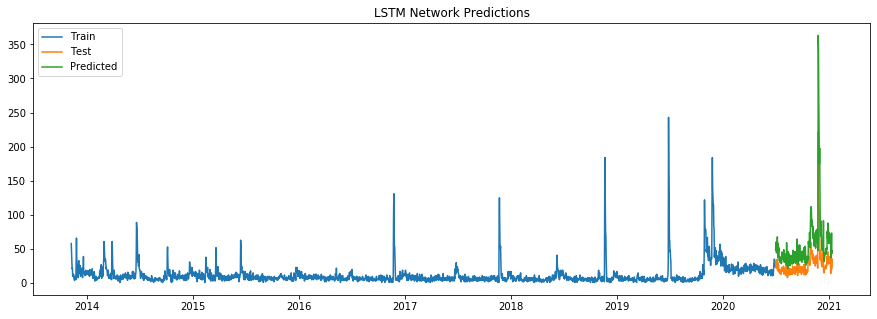

In [149]:
plt.figure(figsize=(15,5))
plt.plot(reviewcount.index[0:-196], raw_values[0:-196], label='Train')
plt.plot(reviewcount.index[-196:], raw_values[-196:], label='Test')
plt.plot(reviewcount.index[-196:], predictions, label='Predicted')
plt.legend(loc='best')
plt.title('LSTM Network Predictions')
plt.show()